In [1]:
import sys
from pathlib import Path

In [2]:
# !{sys.executable} -m pip install -qe ..

In [3]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [6]:
from chequeparser.wrappers.detection_results import DetectionResults
from chequeparser.utilities.ds_utils import concat_ds

In [16]:
from chequeparser.datasets.fileds import FileDS
from chequeparser.datasets.imageds import ImageDS

In [17]:
from chequeparser.models.arch import UL_RTDETR, DOCTR_PRETRAINED
from chequeparser.models.detection.ultralytics import UltralyticsDetect
from chequeparser.models.recognition.doctr import DoctrRecognize
from chequeparser.core.detector import detect
from chequeparser.core.recognizer import recognize

In [116]:
from chequeparser.utilities.misc import partition_list

## config

In [18]:
dir_images = "../data/public/train/images/"

## test pkg

In [19]:
file_ds = FileDS(dir_images)

  0%|          | 0/369 [00:00<?, ?it/s]

2024-02-13 13:46:18.296 | INFO     | chequeparser.utilities.io_utils:get_image_files:30 - Found 369 image files.


In [11]:
model = UltralyticsDetect("../pretrained/best.pt", arch=UL_RTDETR)

In [20]:
len(file_ds)

369

In [22]:
sample_ds = file_ds.sample(batched=True)

In [23]:
sample_ds.names

['1CA2D1E0D2114280A4D5270281561E7C_FACE_jpg.rf.afe5eafc883c214a4c4d3f5a2d02b34b.jpg',
 '26C28C54076D43E5B35A5AF00CFFFF23_FACE_jpg.rf.91d02a4d953ef2aa4aba22557e1f6e3f.jpg',
 '83_jpg.rf.b74bd97bf99b275cb55bc203b57b246b.jpg',
 'X_109_jpeg_jpg.rf.8b941647694b63127bb87fd3d3ff7a8e.jpg',
 '8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg']

5


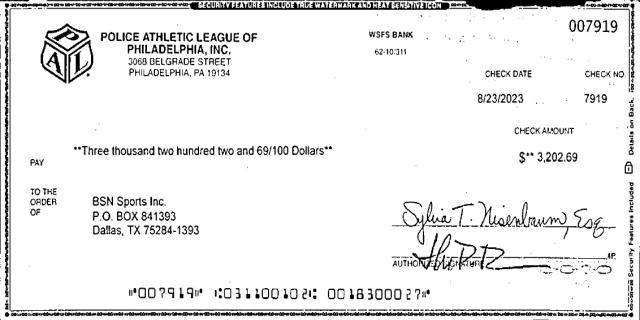

In [871]:
print(len(sample_ds))
sample_ds[4]

In [25]:
results = detect(model, sample_ds, stream=False)

2024-02-13 13:50:10.097 | INFO     | chequeparser.core.detector:detect:36 - Stream mode: False
2024-02-13 13:50:10.098 | INFO     | chequeparser.core.detector:detect:37 - Batched mode: True
2024-02-13 13:50:10.099 | INFO     | chequeparser.core.detector:detect:38 - Running predict on 5 samples


Reloading 'chequeparser.wrappers.detection_results'.

0: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 1: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 2: 640x640 1 micr, 1 orderof, 3: 640x640 1 amnt, 1 date, 1 micr, 1 orderof, 1 payee, 4: 640x640 1 amnt, 1 chk_no, 1 date, 1 micr, 1 orderof, 1 payee, 93.3ms
Speed: 1.6ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


In [72]:
l_payee_results = [result.filter_by_label("payee") for result in results]

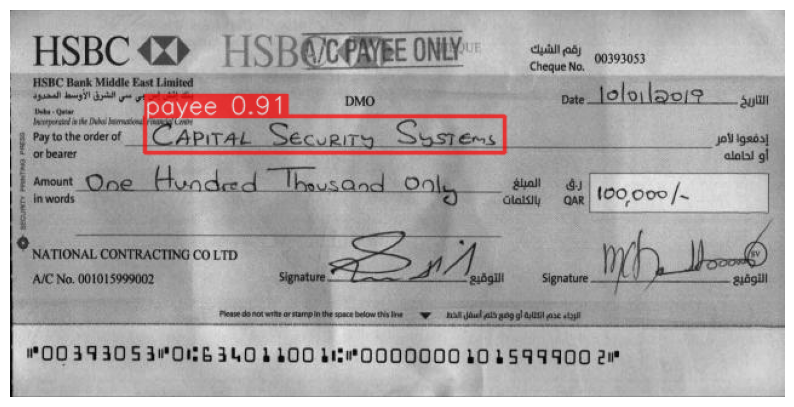

In [80]:
_ = l_payee_results[0].draw(color=(255, 0, 0), display=True)

In [81]:
payee_ds = concat_ds([result.create_ds() for result in l_payee_results])

In [83]:
payee_ds.names

['payee__1CA2D1E0D2114280A4D5270281561E7C_FACE_jpg.rf.afe5eafc883c214a4c4d3f5a2d02b34b.jpg',
 'payee__26C28C54076D43E5B35A5AF00CFFFF23_FACE_jpg.rf.91d02a4d953ef2aa4aba22557e1f6e3f.jpg',
 'payee__X_109_jpeg_jpg.rf.8b941647694b63127bb87fd3d3ff7a8e.jpg',
 'payee__8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg']

### ocr

In [100]:
ocr_model = DoctrRecognize(arch=DOCTR_PRETRAINED, path="crnn_mobilenet_v3_large")

  0%|          | 0/18240683 [00:00<?, ?it/s]

In [101]:
ocr_results = recognize(ocr_model, payee_ds, stream=False)

2024-02-13 14:14:56.843 | INFO     | chequeparser.core.recognizer:recognize:29 - Stream mode: False
2024-02-13 14:14:56.844 | INFO     | chequeparser.core.recognizer:recognize:30 - Batched mode: False
2024-02-13 14:14:56.845 | INFO     | chequeparser.core.recognizer:recognize:31 - Running predict on 4 samples


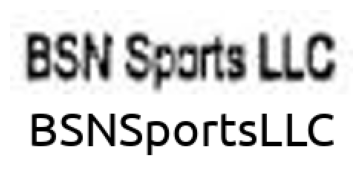

In [105]:
_ = ocr_results[3].draw(display=True)

In [106]:
len(ocr_results)

4

In [117]:
sizes = [len(r) for r in l_payee_results]

In [119]:
part_ocr_results = partition_list(ocr_results, sizes)

In [126]:
for fname, l_res in zip(sample_ds.names, part_ocr_results):
    print(fname, " ".join([r.text for r in l_res]))

1CA2D1E0D2114280A4D5270281561E7C_FACE_jpg.rf.afe5eafc883c214a4c4d3f5a2d02b34b.jpg CAhSa.Suse,
26C28C54076D43E5B35A5AF00CFFFF23_FACE_jpg.rf.91d02a4d953ef2aa4aba22557e1f6e3f.jpg summacraunatie
83_jpg.rf.b74bd97bf99b275cb55bc203b57b246b.jpg 
X_109_jpeg_jpg.rf.8b941647694b63127bb87fd3d3ff7a8e.jpg fenseiinnebluade
8_jpg.rf.93105de5abc572b70639fe0515009e4a.jpg BSNSportsLLC
